This is a technical description of banded ridge regression (see [Nunez-Elizalde, et al., 2019](https://doi.org/10.1016/j.neuroimage.2019.04.012))

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7., 7.]
matplotlib.rcParams['font.size'] = 15

In [3]:
import os
import time

import numpy as np
np.random.seed(1337)
np.set_printoptions(precision=4, suppress=True)

from scipy.stats import zscore
from matplotlib import pyplot as plt

# Banded ridge regression with two feature spaces

When estimating a joint encoding model that consists of two feature spaces, banded ridge regression can be used to fit the model and assign each feature space a different regularization parameter. 

$$Y = X_1 \beta_1 + X_2 \beta_2 + \epsilon$$

$$
\begin{align*}
\beta_1 \sim \mathcal{N}\left(0, \lambda_1^{-2} I_p\right)\\
\beta_2 \sim \mathcal{N}\left(0, \lambda_2^{-2} I_q\right)\\
\end{align*}
$$

However, estimating this model requires cross-validating two regularization parameters ($\lambda_1$ and $\lambda_2$), which can be computationally expensive. In this notebook, we describe a trick that can reduce this computational cost.

### Cartesian grid search 

Suppose we have two feature spaces $X_1$ and $X_2$ each with a corresponding regularization parameter: $\lambda_1$ and $\lambda_2$. In order to find the optimal regularization parameters given the data, we can use cross-validation. This requires us to test many combinations of $\lambda_1$ and $\lambda_2$. For 10 values of $\lambda_1$ and 10 values of $\lambda_2$, a grid search requires a total of $10^2$  evaluations. In general, for $N$ hyperparameter values and $M$ feature spaces, a grid search requires the evaluation fo $N^M$ points. This is computationally expensive and can quickly become computationally intractable.

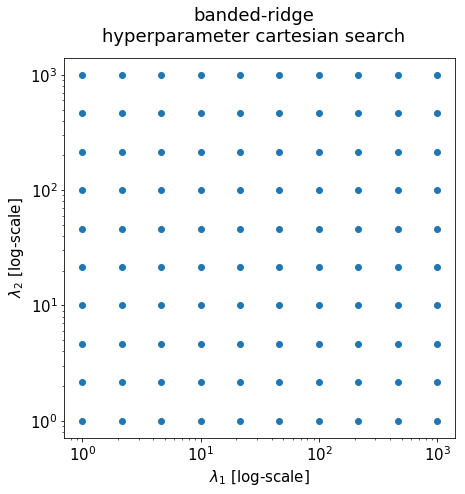

In [4]:
import itertools
lambda_one_candidates = np.logspace(0,3,10)
lambda_two_candidates = np.logspace(0,3,10)

all_pairs = np.asarray(list(itertools.product(lambda_one_candidates, lambda_two_candidates)))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.loglog(all_pairs[:,0], all_pairs[:,1], 'o')
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter cartesian search')

### Polar grid search

Luckily, we can gain some computational efficiency by searching for the hyperparameters $\lambda_1$ and $\lambda_2$ using polar coordinates instead of a cartesian coordinates. 

NB: This computational trick is nothing more than a change in coordinate systems. The hyperparameters $\lambda_1$ and $\lambda_2$ can always be converted to and from cartesian and polar coordinates without loss of generaility.

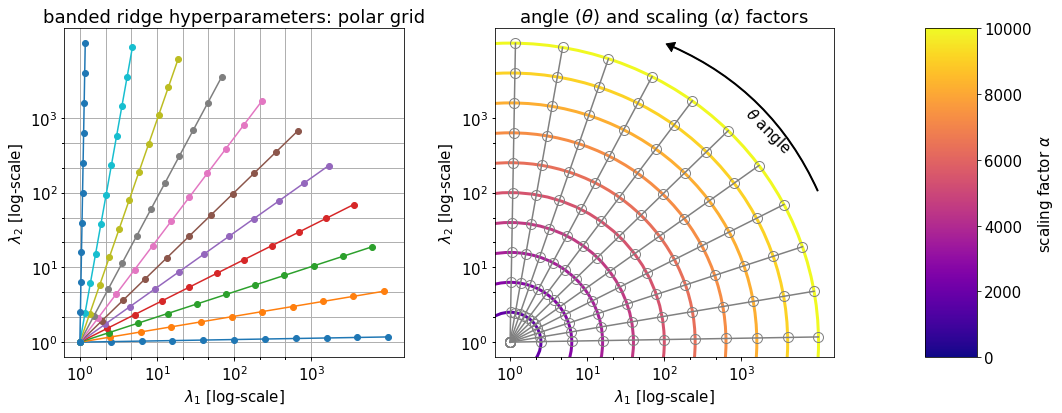

In [5]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(15, 6))

ax = plt.subplot2grid((1, 7), (0, 0), colspan=3, fig=fig)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3, fig=fig)
ax3 = plt.subplot2grid((1, 7), (0, 6), fig=fig)

# Polar sampling
radii = np.logspace(0,4,11)
angles = np.deg2rad(np.linspace(1, 89,11))
for iangle, angle in enumerate(angles):
    ypos = np.sin(angle)*np.log10(radii) # lambda2 values [log10-scale]
    xpos = np.cos(angle)*np.log10(radii) # lambda1 values [log10-scale]

    # plot
    ax.plot(xpos, ypos, 'o-', label=r'$\theta=%0.1f$'%np.rad2deg(angle))
    ax2.plot(xpos, ypos, color='grey', 
             marker='o', markerfacecolor='none', markersize=10, alpha=1.0)

# scaling radii
for cdx, radius in enumerate(radii):
    radius_color = plt.cm.plasma((float(cdx+1)/len(radii)))
    circle = plt.Circle((0,0), np.log10(radius), color=radius_color, fill=False, lw=3.)
    ax2.add_artist(circle)

# angle arrow
style="Simple,tail_width=1.0,head_width=10,head_length=8"
kw = dict(arrowstyle=style, color="k")
arrow = patches.FancyArrowPatch((4,2),(2,4), connectionstyle="arc3,rad=0.2", **kw)
ax2.add_patch(arrow)
ax2.text(3,3, r'$\theta$ angle', rotation=-45)

# Add colorbar for the radii
cbar = matplotlib.colorbar.ColorbarBase(ax3, 
                                        cmap=plt.cm.plasma, 
                                        norm=matplotlib.colors.Normalize(0,10**4),
                                        orientation='vertical')
cbar.set_label(r'scaling factor $\alpha$')

# labels
for axx in [ax, ax2]:
    # Set cartesian sampling as grid
    axx.set_yticks(np.log10(all_pairs[:,0]), minor=True)
    axx.set_xticks(np.log10(all_pairs[:,0]), minor=True)

    axx.set_xlabel(r'$\lambda_1$ [log-scale]')
    axx.set_ylabel(r'$\lambda_2$ [log-scale]')
    axx.set_xticks([0, 1, 2, 3], minor=False)
    axx.set_yticks([0, 1, 2, 3], minor=False)
    __ = axx.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
    __ = axx.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
    
ax.grid(True, which='minor')
__ = ax.set_title('banded ridge hyperparameters: polar grid')
__ = ax2.set_title(r'angle ($\theta$) and scaling ($\alpha$) factors')
plt.tight_layout()

Each ray above corresponds to a set of hyperparameter combinations at a fixed ratio. 
$$r = \left(\frac{\lambda_2}{\lambda_1}\right)$$

The ratio between $\lambda_1$ and $\lambda_2$ defines an angle:
$$\theta = \text{tan}^{-1}\left(\frac{\lambda_2}{\lambda_1}\right)$$

And the angle defines a ratio:
$$\left(\frac{\lambda_2}{\lambda_1}\right) = \text{tan}(\theta)$$

For example, the angle $\theta=45^{\circ}$ defines a set of solutions where the ratio between $\lambda_1$ and $\lambda_2$ is constant and equal to one:

$$\frac{\lambda_2=1}{\lambda_1=1} = \frac{\lambda_2=10}{\lambda_1=10} = \frac{\lambda_2=100}{\lambda_1=100}$$

These solutions can be expressed as a ratio $r$ times a scaling controlled by $\alpha$:

$$\frac{\lambda_2 \alpha}{\lambda_1\alpha} = r \alpha$$

We can define the polar hyperparameter search in terms of ratios and scalings along the unit circle:

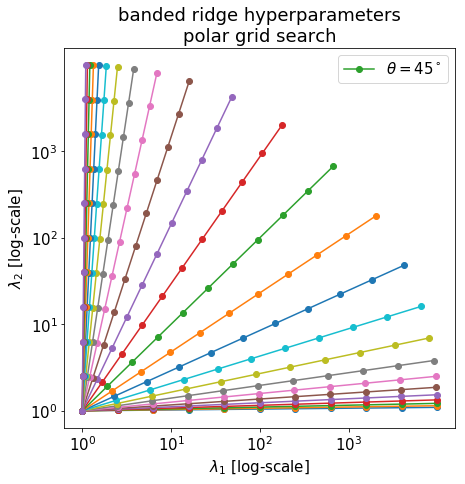

In [6]:
# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ratio in ratios:
    angle = np.arctan(ratio)
    ypos = np.sin(angle)*np.log10(alphas)
    xpos = np.cos(angle)*np.log10(alphas)
    label = None
    if np.allclose(angle, np.deg2rad(45)):
        label = r'$\theta = 45^\circ$'
    ax.plot(xpos, ypos, 'o-', label=label)

ax.set_xticks([0, 1, 2, 3], minor=False)
ax.set_yticks([0, 1, 2, 3], minor=False)
__ = ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
__ = ax.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)

# Labels
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
ax.legend(loc='best')
__ = ax.set_title('banded ridge hyperparameters\npolar grid search')

Note that the ridge regression solution corresponds to the 1:1 ratio or equivalently the 45 degree angle ($\theta = 45^\circ$). This means that the banded ridge solution includes the ridge regression solution as a special case. Therefore, banded ridge regression will perform at least as well as ridge regression.

## Banded ridge with polar search: efficiency

Recall the Tikhohnov regression solution is

$$\hat{\beta}_{Tikhonov} = (X^\top X + C^\top C)^{-1} X^\top Y$$

For banded ridge regression, $C$ consist of a diagonal matrix where the first $p$ entries have a value of $\lambda_1$ and the last $q$ entries have a value of $\lambda_2$.

The solution to the banded ridge regression problem can be expressed as:


$$\hat{\beta}_{banded\_ridge} = 
\begin{bmatrix}
\hat{\beta}_1 \\ 
\hat{\beta}_2
\end{bmatrix} = 
\left(\begin{bmatrix}
X_1^\top X_1 & X_1^\top X_2 \\
X_2^\top X_1 & X_2^\top X_2 \\
\end{bmatrix}
+
\begin{bmatrix}
\lambda_1^2 I_p & 0 \\
0 & \lambda_2^2 I_q \\
\end{bmatrix} \right)^{-1}
\begin{bmatrix}
X_1^\top \\ X_2^\top
\end{bmatrix} Y
$$

In order to select the optimal regularization parameters for each feature space $\lambda^\ast_1$ and $\lambda^\ast_2$, we have to perform cross-validation and compute the solution for each candidate $\lambda_1$ and $\lambda_2$: 

$$\hat{\beta}_{banded\_ridge}^{\lambda^\text{'}_1, \lambda^\text{'}_2}$$

Cross-validating $N$ hyperparameter combinations (i.e. $N$ $\lambda_1$ and $\lambda_2$ pairs) will take $N$ times the amount of time it takes to compute the solution for one. This is a costly endeavour because the solution requires computing the inverse:

$$\left(X^\top X + C^\top C\right)^{-1}$$

It turns out that we can achieve better computational performance by using the standard transform and a polar grid search over the hyperparameters $\lambda_1$ and $\lambda_2$. This trick allows us to solve multiple solutions for a given $\frac{\lambda_2}{\lambda_1}$ ratio at the cost of only one singular value decomposition (SVD) and many matrix multiplies. Because the computational cost of a matrix  multiplication is lower than the cost of computing an inverse or an SVD, this approach is more efficient than performing $N$ SVD decompositions. And so, performing the hyperparameter search using polar coordinates is faster than using cartesian coordinates.

## Banded ridge with polar search: math

In what follows, we show how to solve the banded ridge regression problem using the standard transform. We show the numerical and mathematical steps required to go from the standard form solution to the Tikhonov solution.

We first generate some random data.

In [7]:
nsamples = 1000
npfeatures = 100
nqfeatures = 200
nresponses = 100
X1 = np.random.randn(nsamples, npfeatures)
X2 = np.random.randn(nsamples, nqfeatures)
Ytrain = np.random.randn(nsamples, nresponses)

We next compute the banded ridge regression solution directly

$$\hat{\beta}_{banded\_ridge} = (X^\top X + C^\top C)^{-1} X^\top Y$$

where 
$$C = \begin{bmatrix}
\lambda_1 I_p & 0 \\
0 & \lambda_2 I_q \\
\end{bmatrix}
$$

In the following examples, we set $\lambda_1 = 30$ and $\lambda_2 = 20$.

In [8]:
# Direct banded ridge solution
lambda_one = 30.0
lambda_two = 20.0

bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
C = np.diag(bands)
Xjoint = np.hstack([X1, X2])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + np.dot(C.T, C))
XTY = np.dot(Xjoint.T, Ytrain)
solution_direct_solution = np.dot(LH, XTY)

Using the standard transform, we see that the banded ridge regression problem has a simple structure:

$$A = X C^{-1} = \left[\frac{X_1}{\lambda_1} \frac{X_1}{\lambda_2}\right]$$

The standard form solution to the banded ridge regression problem can be expressed as

$$\hat{\beta}_{banded\_standard} = (A^\top A + I_{p+q})^{-1} A^\top Y$$

Finally, the solution to the banded ridge regression problem is obtained by multiplying the standard form solution by $C^{-1}$:

$$\hat{\beta}_{banded\_ridge} = C^{-1}\hat{\beta}_{banded\_standard}$$

In what follows, we validate this result numerically.

In [9]:
# Standard form solution
lambda_one = 30.0
lambda_two = 20.0
alpha = 1.0
Xjoint = np.hstack([X1/lambda_one, X2/lambda_two])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + (alpha**2)*np.eye(Xjoint.shape[1]))
RH = np.dot(Xjoint.T, Ytrain)
bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
Cinv = np.diag(bands**-1)
solution_banded_standard = np.dot(LH, RH)
solution_banded_stand2tik = np.dot(Cinv, solution_banded_standard)

print(np.corrcoef(solution_banded_stand2tik.ravel(), solution_direct_solution.ravel()))
print(np.allclose(solution_banded_stand2tik, solution_direct_solution))

[[1. 1.]
 [1. 1.]]
True


Thus far, we have been using the raw regularization parameters $\lambda_1$ and $\lambda_2$. However, note that the ratio of the regularization parameters is the same for both $\lambda_1=30, \lambda_2 = 20$ and $\lambda_1=3, \lambda_2 = 2$:

$$\frac{\lambda_2=20}{\lambda_1=30} = \frac{2}{3}\times 10$$

The standard form solution to the banded ridge regression problem can be modified to accomodate this fact

$$A = \left[\frac{X_1}{\lambda_1 / 10} \frac{X_2}{\lambda_2/10}\right]$$

However, the factor $10$ needs to be applied back to the solution in order to obtain an exact result

$$\hat{\beta}_{banded\_standard} = 10\times (A^\top A + 10^2 I_{p+q})^{-1} A^\top Y$$

In this example, the scaling factor takes a value of 10. More generally, we refer to the scaling factor as $\alpha$.

In [10]:
# Scaling the standard form solution with alpha
lambda_one = 3.0
lambda_two = 2.0
alpha = 10.0

Xjoint = np.hstack([X1/lambda_one, X2/lambda_two])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + (alpha**2.0)*np.eye(Xjoint.shape[1]))
RH = np.dot(Xjoint.T, Ytrain)
solution_standard_scaled = np.dot(LH, RH)*alpha

# Check the standard form solution
print(np.corrcoef(solution_standard_scaled.ravel(), solution_banded_standard.ravel()))
print(np.allclose(solution_standard_scaled, solution_banded_standard))

# Check the tikhonov solution
solution_bandstd2tik = np.dot(Cinv, solution_standard_scaled)
print(np.corrcoef(solution_bandstd2tik.ravel(),  solution_direct_solution.ravel()))
print(np.allclose(solution_bandstd2tik, solution_direct_solution))

[[1. 1.]
 [1. 1.]]
True
[[1. 1.]
 [1. 1.]]
True


For any given ratio $r = \frac{\lambda_2}{\lambda_1}$, multiple regularization parameters can be obtained by a simple scaling with a constant $\alpha$:

$$\left(\frac{\lambda_2}{\lambda_1}\right)\alpha = r\alpha$$

And for a given $\alpha$, the standard transform for banded ridge can be expressed as
$$A = \left[\frac{X_1}{\lambda_1 / \alpha} \frac{X_2}{\lambda_2/\alpha}\right]$$

The banded ridge solution for a given $\alpha$ is obtained from the standard transform as:

$$\hat{\beta}_{banded\_ridge} = \alpha C^{-1} (A^\top A + \alpha^2 I_{p+q})^{-1} A^\top Y$$

Expanding $\alpha C^{-1}$:

$$ \hat{\beta}_{banded\_ridge} = 
\begin{bmatrix} 
\frac{\alpha}{\lambda_1} I_p & 0 \\
0 & \frac{\alpha}{\lambda_2} I_q \\
\end{bmatrix}
(A^\top A + \alpha^2 I_{p+q})^{-1} A^\top Y $$

### Why would you ever want to do that?

It tuns out we can solve this problem very efficiently for multiple values of $\alpha$ using the fact that 

$$\left(A^\top A + \alpha^2 I \right)^{-1}$$

is simultaneously diagonalizable. This fact allows us to compute solutions for $n$ values of $\alpha$ using only one singular value decomposition (SVD) and $n$ matrix multiplies.

To illustrate, recall the SVD of $A$:
$$U S V^\top = A $$

We substitute $A$ with its SVD decomposition inside the inverse term:

$$\left(A^\top A + \alpha^2 I \right)^{-1} = \left(V S^2 V^\top + \alpha^2 I \right)^{- 1}$$

Because $V$ is an orthonormal matrix and $S$ and $\alpha^2 I$ are diagonal matrices, the inverse of their sum is simultaneously diagonalizable and can be expressed as:

$$
\begin{align*}
\left(A^\top A + \alpha^2 I \right)^{-1} &= \left(V \left(S^2 + \alpha^2 I\right) V^\top \right)^{- 1}\\
\left(A^\top A + \alpha^2 I \right)^{-1} &= V \left(\frac{1}{S^2 + \alpha^2 I}\right) V^\top
\end{align*}
$$

And because
$$A^\top Y = V S U^\top Y,$$

the expression for the standard form solution can be further simplified:

$$\left(A^\top A + \alpha^2 I \right)^{-1} A^\top Y = V \left(\frac{S}{S^2 + \alpha^2 I}\right) U^\top Y$$

And so, for a given ratio $r = \frac{\lambda^\text{'}_2}{\lambda^\text{'}_1}$, the solution becomes:

$$\hat{\beta}^{{\lambda^\text{'}_1, \lambda^\text{'}_2}}_{banded\_standard} = V D U^\top Y$$

where

$$D \equiv \left(\frac{S}{S^2 + \alpha^2 I}\right)$$

Because $U^\top Y$ can be cached, computing the solutions for multiple $\alpha$ scalings requires only matrix multiplies and we only have to compute the SVD once per ratio.

In [11]:
# Simultaneous diagonalizability trick: one alpha
lambda_one = 3.0
lambda_two = 2.0
alpha = 10.0

A = np.hstack([X1/lambda_one, X2/lambda_two])

start_time = time.time()
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alpha**2))

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)
one_dur = time.time() - start_time
print('Duration: %0.04f'%one_dur)

# Check the standard form solution
print(np.corrcoef(solution_svd_standard.ravel(), solution_banded_standard.ravel()))
print(np.allclose(solution_svd_standard, solution_banded_standard))

# Check the tikhonov solution
print(np.corrcoef(solution_svd_bandstd2tik.ravel(),  solution_direct_solution.ravel()))
print(np.allclose(solution_svd_bandstd2tik, solution_direct_solution))

Duration: 0.0331
[[1. 1.]
 [1. 1.]]
True
[[1. 1.]
 [1. 1.]]
True


We now show that this formulation allows us to compute the solution for multiple values of $\alpha$ much faster


In [12]:
# Simultaneous diagonalizability trick: multiple alphas
lambda_one = 3.0
lambda_two = 2.0
alphas = np.logspace(0,4,10)

A = np.hstack([X1/lambda_one, X2/lambda_two])

start_time = time.time()
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
for alpha in alphas:
    UTY = np.dot(U.T, Ytrain)
    D = np.diag(S / (S**2 + alpha**2))
    solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
    solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)
    
multiple_dur = time.time() - start_time
factor = one_dur*len(alphas) / multiple_dur
print('Total duration for %i alphas: %0.04f'%(len(alphas), multiple_dur))
print('Trick is %0.01f times faster'%factor)

Total duration for 10 alphas: 0.0429
Trick is 7.7 times faster


## tikreg: banded rige with polar search

`tikreg` ([github.com/gallantlab/tikreg](http://github.com/gallantlab/tikreg)) is capable of performing a hyperpameter search in polar coordinates. To see it in action, we first generate some fake data.

In [13]:
from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

In [14]:
# Generate some data
B1, (X1, X1tst), (Y1trn, Y1tst) =  tikutils.generate_data(n=nsamples, p=npfeatures, v=int(nresponses/2), testsize=100)
B2, (X2, X2tst), (Y2trn, Y2tst) =  tikutils.generate_data(n=nsamples, p=nqfeatures, v=int(nresponses/2), testsize=100)

Ytrain = np.c_[Y1trn, Y2trn]
Ytest = np.c_[Y1tst, Y2tst]

### tikreg example: solving for one set of hyperparameters

We first solve this problem directly so we can check the answer given by `tikreg`. To begin, we use one value for each of $\lambda_1$, $\lambda_2$ and $\alpha$.

In [15]:
## DIRECT SOLUTION

# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

# Solve for one hyperparameter set only
# We will use this solution to test the tikreg implementation
ratio = ratios[16]
alpha = alphas[1]

angle = np.arctan(ratio)
lambda_one = np.cos(angle)*alpha
lambda_two = np.sin(angle)*alpha

bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
Cinv = np.diag(bands**-1)

A = np.hstack([X1/lambda_one, X2/lambda_two])
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alpha**2))

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)

print(np.rad2deg(angle), ratio, alpha, lambda_one, lambda_two)

(77.84183577448114, 4.6415888336127775, 2.51188643150958, 0.5290310600635536, 2.455544661025322)


Next, we solve the problem using `tikreg`. The relevant function is `tikreg.models.estimate_stem_wmvnp()`. 

In [16]:
# Use tikreg to find the solution
X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[lambda_one])
X2_prior = spatial_priors.SphericalPrior(X2, hyparams=[lambda_two])
# A temporal prior is unnecessary, so we specify no delays 
temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

fit_banded_polar = models.estimate_stem_wmvnp([X1, X2], Ytrain, 
                                              [X1tst, X2tst],Ytest,
                                              feature_priors=[X1_prior, X2_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=[alpha],
                                              folds=(1,5), # 1x 5-fold cross-validation
                                              performance=True,
                                              weights=True,
                                              verbosity=False)

`tikreg.estimate_stem_wmvnp()` solves the regression problem in the dual space using kernel regression. Therefore, the weights given by `tikreg` are the kernel weights ($\hat{\omega} \in \mathbb{R}^{n \times v}$), not the primal weights (i.e. $\hat{\beta}_{banded\_ridge} \in \mathbb{R}^{(p + q) \times v}$). This means that we'll have to project the kernel weights onto the feature spaces in order to obtain the primal weights:

$$\hat{\beta}_{banded\_ridge} = C^{-1}
\begin{bmatrix}
X_1^\top\\
X_2^\top 
\end{bmatrix}
\hat{\omega} \alpha,$$

where

$$C^{-1} = \begin{bmatrix}
\lambda_1^{-1} I_p & 0 \\
0 & \lambda_2^{-1} I_q \\
\end{bmatrix}
$$


We can check the results for numerical accuracy.


In [17]:
## Verify the results numerically

lambda_one_scaled, lambda_two_scaled = fit_banded_polar['spatial'].squeeze()
ridge_scaled = fit_banded_polar['ridges'].squeeze()
print(lambda_one_scaled, lambda_two_scaled, ridge_scaled)
kernel_weights = fit_banded_polar['weights']

Xtmp = np.c_[X1/lambda_one_scaled, X2/lambda_two_scaled]
weights_standard = np.dot(Xtmp.T, kernel_weights*alpha)

# Standard form solutions
weights_x1 = weights_standard[:X1.shape[1],:]
weights_x2 = weights_standard[X1.shape[1]:,:]

sweights_x1 = solution_svd_standard[:X1.shape[1],:]
sweights_x2 = solution_svd_standard[X1.shape[1]:,:]

print('Standard transform weights for X1:')
print(weights_x1[:1,:5])
print(sweights_x1[:1,:5])
print(np.corrcoef(weights_x1.ravel(), sweights_x1.ravel())[0,1])
print(np.allclose(weights_x1, sweights_x1))

print('Standard transform weights for X2:')
print(weights_x2[:1,:5])
print(sweights_x2[:1,:5])
print(np.corrcoef(weights_x2.ravel(), sweights_x2.ravel())[0,1])
print(np.allclose(weights_x2, sweights_x2))

assert np.allclose(weights_standard, solution_svd_standard)


# TIkhonov solutions
bands = np.asarray([lambda_one_scaled]*X1.shape[1] + [lambda_two_scaled]*X2.shape[1])
Cinv = np.diag(bands**-1.0)
weights = np.dot(Cinv, weights_standard)

# full eq: np.dot(np.hstack([X1/(lambda_one_scaled**2.), X2/(lambda_two_scaled**2.)]).T, kernel_weights*alpha)
weights_x1t = weights[:X1.shape[1],:]
weights_x2t = weights[X1.shape[1]:,:]

tweights_x1 = solution_svd_bandstd2tik[:X1.shape[1],:]
tweights_x2 = solution_svd_bandstd2tik[X1.shape[1]:,:]

print('Tikhonov weights for joint model')
print(weights_x1t[:1,:5])
print(tweights_x1[:1,:5])
print(np.corrcoef(weights_x1t.ravel(), tweights_x1.ravel())[0,1])
print(weights_x2t[:1,:5])
print(tweights_x2[:1,:5])
print(np.corrcoef(weights_x2t.ravel(), tweights_x2.ravel())[0,1])

print('Full model weights')
print(np.corrcoef(weights.ravel(),  solution_svd_bandstd2tik.ravel())[0,1])
assert np.allclose(weights,  solution_svd_bandstd2tik)
print(weights.shape)

(0.5290310600635536, 2.455544661025322, array(2.5119))
Standard transform weights for X1:
[[ 0.8075 -0.5118 -1.5011 -0.1354  1.1579]]
[[ 0.8075 -0.5118 -1.5011 -0.1354  1.1579]]
0.9999999999999999
True
Standard transform weights for X2:
[[-0.1374  0.1591  0.4406  0.2596 -0.1629]]
[[-0.1374  0.1591  0.4406  0.2596 -0.1629]]
1.0
True
Tikhonov weights for joint model
[[ 1.5264 -0.9675 -2.8374 -0.2559  2.1888]]
[[ 1.5264 -0.9675 -2.8374 -0.2559  2.1888]]
1.0
[[-0.056   0.0648  0.1794  0.1057 -0.0664]]
[[-0.056   0.0648  0.1794  0.1057 -0.0664]]
1.0
Full model weights
1.0
(300, 100)


### tikreg: solving for multiple of hyperparameters using polar search

We next show how to use `tikreg` to solve for multiple ratios and scalings using polar coordinates. 
First, we show the polar grid defined by the range of ratios and scalings that we wish to test:

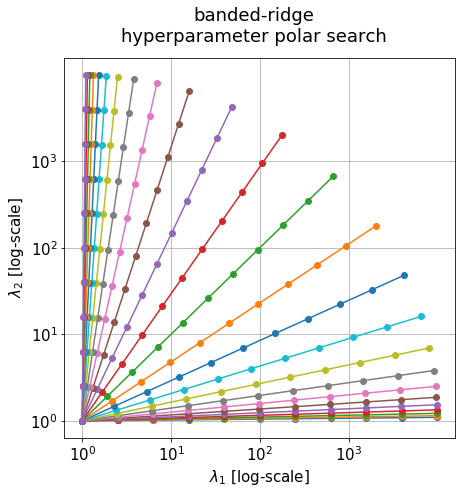

In [18]:
# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ratio in ratios:
    angle = np.arctan(ratio)
    ypos = np.sin(angle)*np.log10(alphas)
    xpos = np.cos(angle)*np.log10(alphas)
    ax.plot(xpos, ypos, 'o-')

ax.set_xticks([0, 1, 2, 3], minor=False)
ax.set_yticks([0, 1, 2, 3], minor=False)
__ = ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
__ = ax.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)

# Labels
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter polar search')
ax.grid(True)

The function `tikreg.estimate_stem_wmvnp()` already implements polar grid search. In order to use it, a couple of things must be specified. 


#### Define the priors

First, one of the feature spaces must serve as the reference feature space. To achieve this, the MVN prior for this feature space must only contain one hyperparameter to test. In this example, we use $X_1$ as our reference feature space and set $\lambda_1=1.0$:

`>>> X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[1.0])`

The other feature spaces will contain the ratios that we wish to test. In this case, the only other feature space is $X_2$:

`>>> X2_prior = spatial_priors.SphericalPrior(X2, hyparams=ratios)`

If more than two features spaces are used, then all other feature spaces must also specify all the ratios to test.

#### Force hyperparameter normalization 

Second, the keyword argument `normalize_hyparams=True` must be set. This forces `tikreg` to normalize the hyperparameters such that they lie on the unit circle. This is achieved by dividing the hyperparameters by their norm. Because $\lambda_1$ is always 1:

$$[\lambda^{\text{normalized}}_1,\lambda^{\text{normalized}}_2] = \frac{[1.0, \lambda_2]}{||[1.0, \lambda_2]||_2}  $$

In [19]:
# The first feature space is the reference for the ratio (l2/l1) and so l1 is fixed as 1.
X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[1.0]) 

# The second feature space contains the ratios to try
# These will be normalized internally in order to sample from the unit circle
X2_prior = spatial_priors.SphericalPrior(X2, hyparams=ratios)

temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

fit_banded_polar = models.estimate_stem_wmvnp([X1, X2], Ytrain,
                                              [X1tst, X2tst],Ytest,
                                              feature_priors=[X1_prior, X2_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=alphas,           # Solution for all alphas
                                              normalize_hyparams=True, # Normalizes the ratios
                                              folds=(1,5),
                                              performance=True,
                                              weights=True,
                                              verbosity=False)

Next, we compute the model weights for each voxel separately. To achieve this, we first find the optimal set of hyperparameters ($\lambda_1$, $\lambda_2$, $\alpha$) for each voxel

In [20]:
voxelwise_optimal_hyperparameters = fit_banded_polar['optima']
print(voxelwise_optimal_hyperparameters.shape)

(100, 4)


We then iterate through each voxel and convert the kernel weights ($\omega$) into the primal weights ($\beta$).

In [21]:
kernel_weights = fit_banded_polar['weights']
primal_weights = []
for voxid, (temporal_lambda, lambda_one, lambda_two, alpha) in enumerate(voxelwise_optimal_hyperparameters):
    ws = np.dot(np.hstack([X1/lambda_one**2, X2/lambda_two**2]).T, kernel_weights[:,voxid]*alpha)
    primal_weights.append(ws)
primal_weights = np.asarray(primal_weights).T
print(primal_weights.shape)

(300, 100)


The code above requires iterating through each individual voxel, which can be very slow. However, because the model is linear, we can compute the individual voxel solutions much faster using matrix multiplication. To achieve this, we first store the optimal hyperparameters ($\alpha$, $\lambda_1$, $\lambda_2$) for each voxel $i$ into vectors:

$$
\begin{align*}
\vec{\alpha} &= [\alpha_1, \alpha_2, \ldots,\alpha_i, \ldots \alpha_v]\\
\vec{\lambda_1} &= [\lambda_{1,1}, \lambda_{1,2}, \ldots,\lambda_{1,i}, \ldots \lambda_{1,v}]\\
\vec{\lambda_2} &= [\lambda_{2,1}, \lambda_{2,2}, \ldots,\lambda_{1,i}, \ldots \lambda_{2,v}]
\end{align*}
$$

where the subscript $i$ in $\alpha_i$, $\lambda_{1,i}$ and $\lambda_{2,i}$ corresponds to the voxel index. 

Each vector contains $v$ entries, one for each of the responses (e.g. voxels, neurons, etc).

In [22]:
alphas = voxelwise_optimal_hyperparameters[:,-1]
lambda_ones = voxelwise_optimal_hyperparameters[:,1]
lambda_twos = voxelwise_optimal_hyperparameters[:,2]


Once we have stored the hyperparameters into separate vectors, we can
use matrix multiplication to convert the estimated kernel weights 
($\hat{\omega} \in \mathbb{R}^{n \times v}$) into primal weights ($\hat{\beta}_{banded\_ridge} \in \mathbb{R}^{(p + q) \times v}$) for each feature space separately for each voxel:

$$
\hat{\beta}_1 = X_1^\top \hat{\omega} 
\left[\begin{array}{ccc}
\alpha_1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \alpha_v \\
\end{array}\right]
\left[\begin{array}{ccc}
\left(\lambda_{1,1}\right)^{-2} & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \left(\lambda_{1,v}\right)^{-2} \\
\end{array}\right]
$$

where $\hat{\beta}_1 \in \mathbb{R}^{p \times v}$ is the matrix containing all the $p$ weights for feature space $X_1$ for all $v$ voxels.

$$
\hat{\beta}_2 = X_2^\top \hat{\omega} 
\left[\begin{array}{ccc}
\alpha_1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \alpha_v \\
\end{array}\right]
\left[\begin{array}{ccc}
\left(\lambda_{2,1}\right)^{-2} & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \left(\lambda_{2,v}\right)^{-2} \\
\end{array}\right]
$$

where $\hat{\beta}_2 \in \mathbb{R}^{q \times v}$ is the matrix containing all the $q$ weights for feature space $X_2$ for all $v$ voxels.

To obtain the banded ridge weight estimate, we simply concatenate both weight matrices:

$$\hat{\beta}_{banded\_ridge} = 
\begin{bmatrix}
\hat{\beta}_1\\
\hat{\beta}_2
\end{bmatrix}
$$

In [23]:
kernel_weights = fit_banded_polar['weights']
weights_x1 = np.linalg.multi_dot([X1.T, kernel_weights, np.diag(alphas), np.diag(lambda_ones**-2)])
weights_x2 = np.linalg.multi_dot([X2.T, kernel_weights, np.diag(alphas), np.diag(lambda_twos**-2)])
weights_joint = np.vstack([weights_x1, weights_x2])
print(weights_joint.shape)
assert np.allclose(weights_joint, primal_weights)

(300, 100)
